In [ ]:
# @title Install dependencies
!pip install nilearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 74.3 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

In [ ]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "/content/hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('/content')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

In [ ]:
sub = np.count_nonzero(subjects)

In [ ]:
print(sub)

100


In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [ ]:
print(regions)

[['R_V1' 'R_MST' 'R_V6' ... 'L_PI' 'L_a32pr' 'L_p24']
 ['Visual1' 'Visual2' 'Visual2' ... 'Cingulo-Oper' 'Cingulo-Oper'
  'Cingulo-Oper']
 ['2.209' '2.05561' '2.1498' ... '1.74335' '1.73082' '1.65968']]


In [ ]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

In [ ]:
print(subjects)

['100307' '100408' '101915' '102816' '103414' '103515' '103818' '105115'
 '105216' '106016' '106319' '110411' '111009' '111312' '111514' '111716'
 '113215' '113619' '114924' '115320' '117122' '117324' '118730' '118932'
 '119833' '120111' '120212' '122317' '123117' '124422' '125525' '126325'
 '127933' '128632' '129028' '130013' '130316' '130922' '131924' '133625'
 '133827' '133928' '134324' '135932' '136833' '137128' '138231' '138534'
 '139637' '140824' '142828' '143325' '148032' '148335' '149337' '149539'
 '150524' '151223' '151526' '151627' '153025' '153429' '154431' '156233'
 '156637' '157336' '158035' '158540' '159239' '159340' '160123' '161731'
 '162329' '162733' '163129' '163432' '167743' '172332' '175439' '176542'
 '178950' '182739' '185139' '188347' '189450' '190031' '192439' '192540'
 '193239' '194140' '196144' '196750' '197550' '198451' '199150' '199655'
 '200614' '201111' '201414' '205119']


In [ ]:
print(load_single_timeseries(subject='100307', experiment='WM', run=0))

[[ 133.73575285   83.6367881    54.77566969 ...  -55.3652463
   -71.56433972  -67.91427668]
 [  62.86462918   72.5606484    45.36647951 ...   16.62957316
    -1.63379033  -79.09247917]
 [ 136.59607877  118.90086949   79.92411644 ...   16.64831296
   -16.59801104  -20.01792497]
 ...
 [ 240.97672543  169.70048594   49.62560614 ...  -60.18963575
   -38.1596027   -92.38191339]
 [  31.71782025   22.12513074   70.72774609 ...  -12.06744281
    12.27620038  -33.42965595]
 [  98.49168155  -16.66642055   28.40810127 ...  -90.05270153
  -154.87161654 -176.44541436]]


In [ ]:
my_exp = 'WM'
my_subj = subjects[1]
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data)

[[  -7.42494876    0.51553553   -5.82729561 ... -159.09944074
  -124.33521917 -111.9084446 ]
 [  -5.29708979   -4.54762947   22.22318673 ...   -3.00516185
   -26.73187855    9.83032591]
 [  87.9431484    73.73196477   72.1954985  ... -163.88132442
  -160.80001566 -123.98935763]
 ...
 [ 127.8462894   198.76116319  146.35634799 ...  -65.68601229
  -101.53197082    8.95230652]
 [   9.44325132  -25.52195864   99.42597837 ...  -67.64276247
     4.00345487  -30.4108594 ]
 [ 355.88604763  230.97993233  177.63045765 ... -218.58578359
  -112.02311522 -151.45453696]]


In [ ]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)

In [ ]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


zbk_body_activity = average_frames(data, evs, my_exp, '0bk_body')
tbk_body_activity = average_frames(data, evs, my_exp, '2bk_body')
contrast = zbk_body_activity - tbk_body_activity  # difference between nback tasks

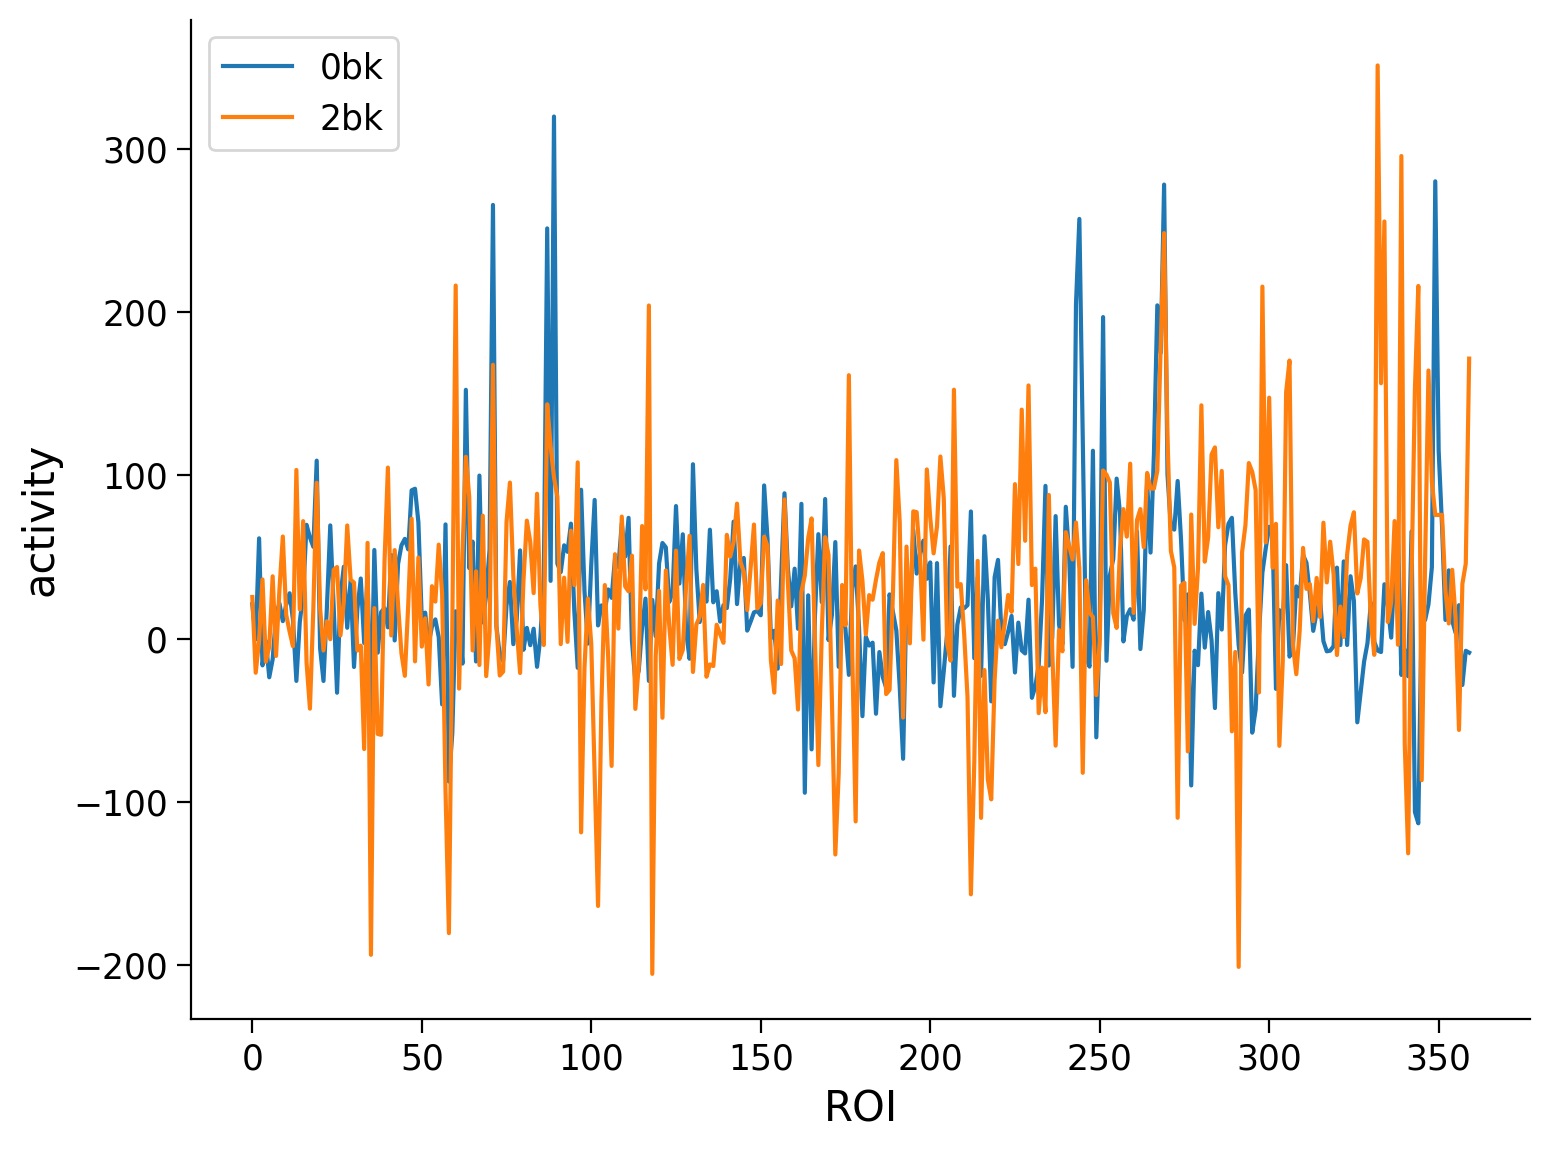

In [ ]:
# Plot activity level in each ROI for both conditions
plt.plot(zbk_body_activity,label='0bk')
plt.plot(tbk_body_activity,label='2bk')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

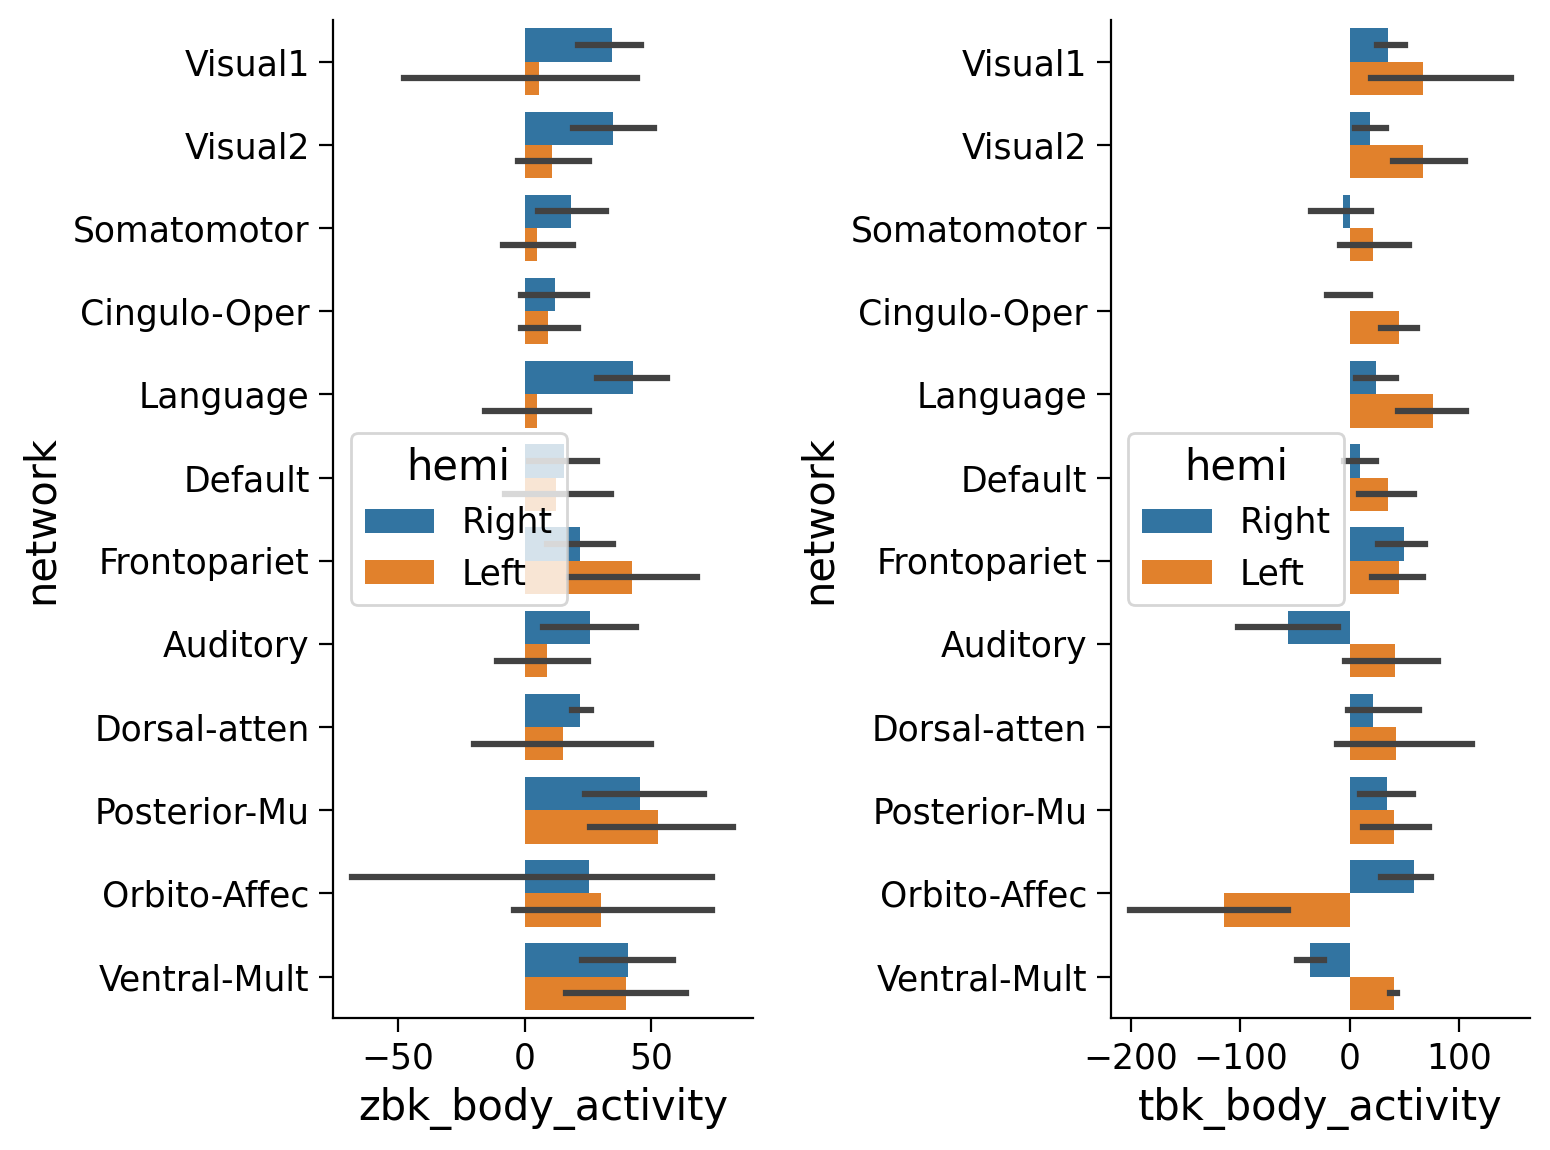

In [ ]:
df = pd.DataFrame({'zbk_body_activity' : zbk_body_activity,
                   'tbk_body_activity' : tbk_body_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='zbk_body_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='tbk_body_activity', data=df, hue='hemi',ax=ax2)
plt.show()

In [ ]:
group_contrast = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    zbk_body_activity = average_frames(data, evs, my_exp, '0bk_body')
    tbk_body_activity = average_frames(data, evs, my_exp, '2bk_body')

    contrast = zbk_body_activity - tbk_body_activity
    group_contrast += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

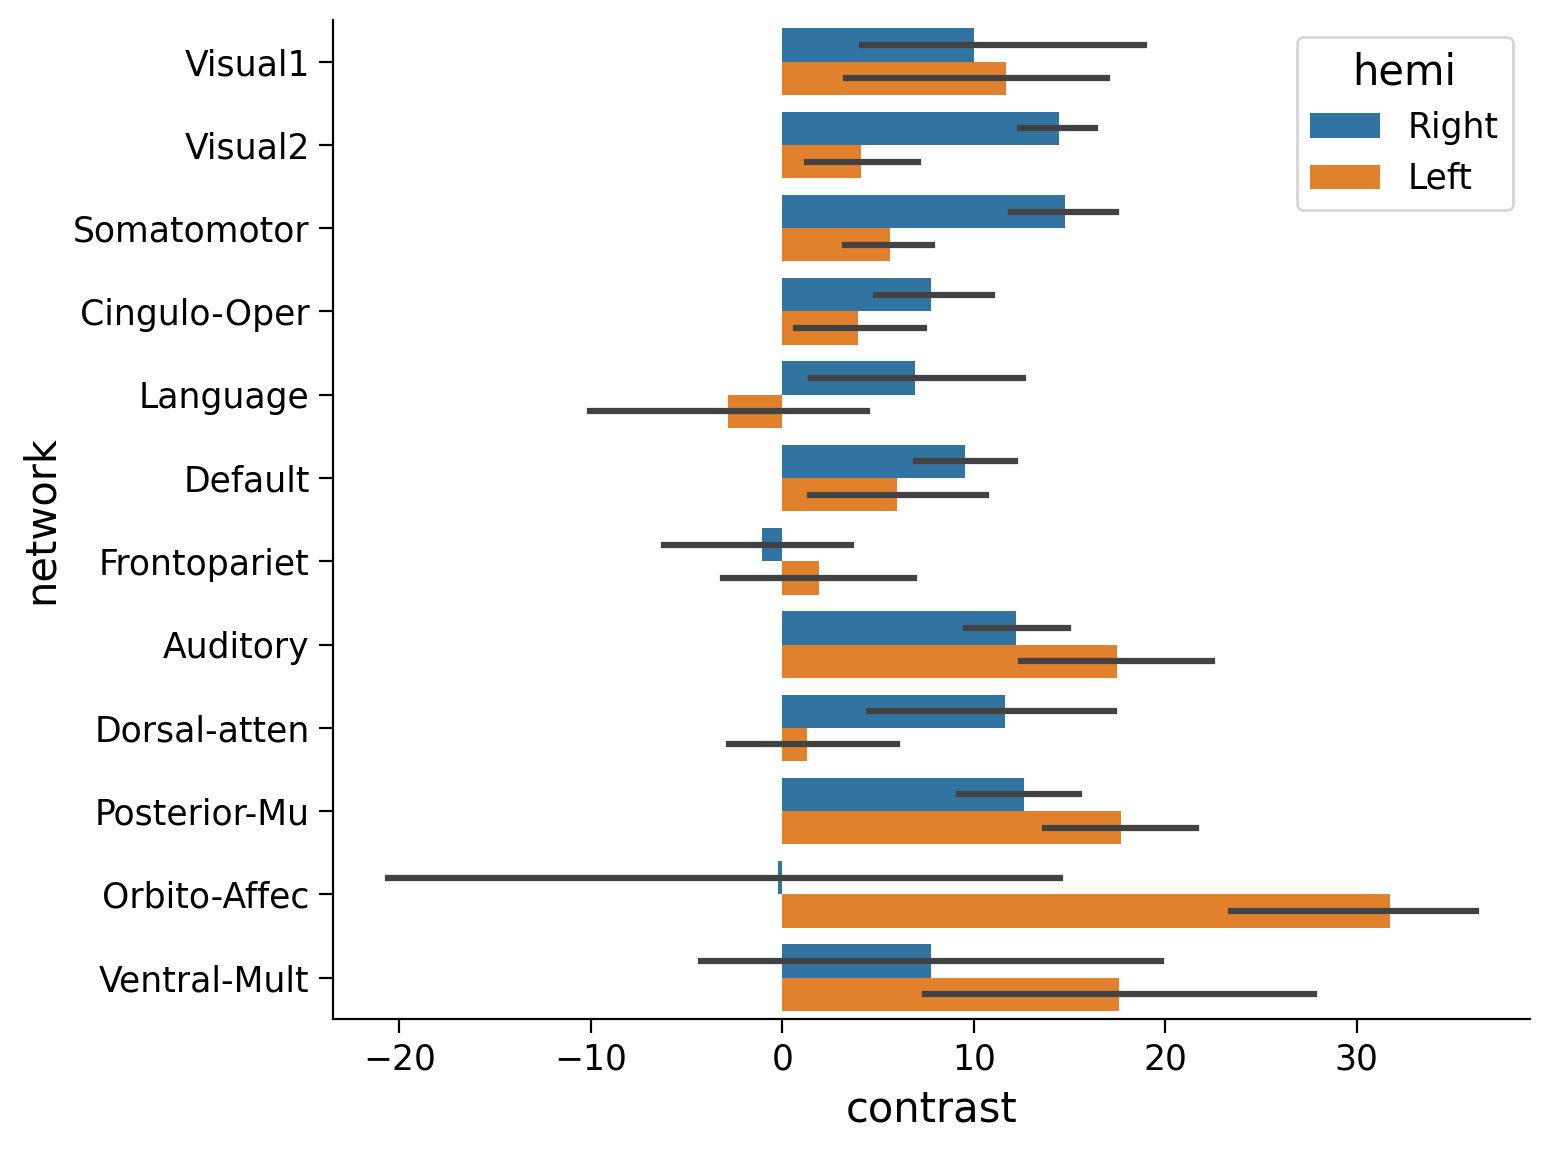

In [ ]:
df = pd.DataFrame({'contrast' : group_contrast,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']
                   })
# we will plot the left foot minus right foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.show()

In [ ]:
# @title NMA provides an atlas. Run this cell to download it
import os, requests

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

In [ ]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)

/tmp/ipython-input-22-2421759442.py:7: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.view_surf(fsaverage['infl_left'],


In [ ]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


zbk_body_activity = average_frames(data, evs, my_exp, '0bk_body')
tbk_body_activity = average_frames(data, evs, my_exp, '2bk_body')
contrast1 = zbk_body_activity - tbk_body_activity  # difference between nback tasks

zbk_faces_activity = average_frames(data, evs, my_exp, '0bk_faces')
tbk_faces_activity = average_frames(data, evs, my_exp, '2bk_faces')
contrast2 = zbk_faces_activity - tbk_faces_activity

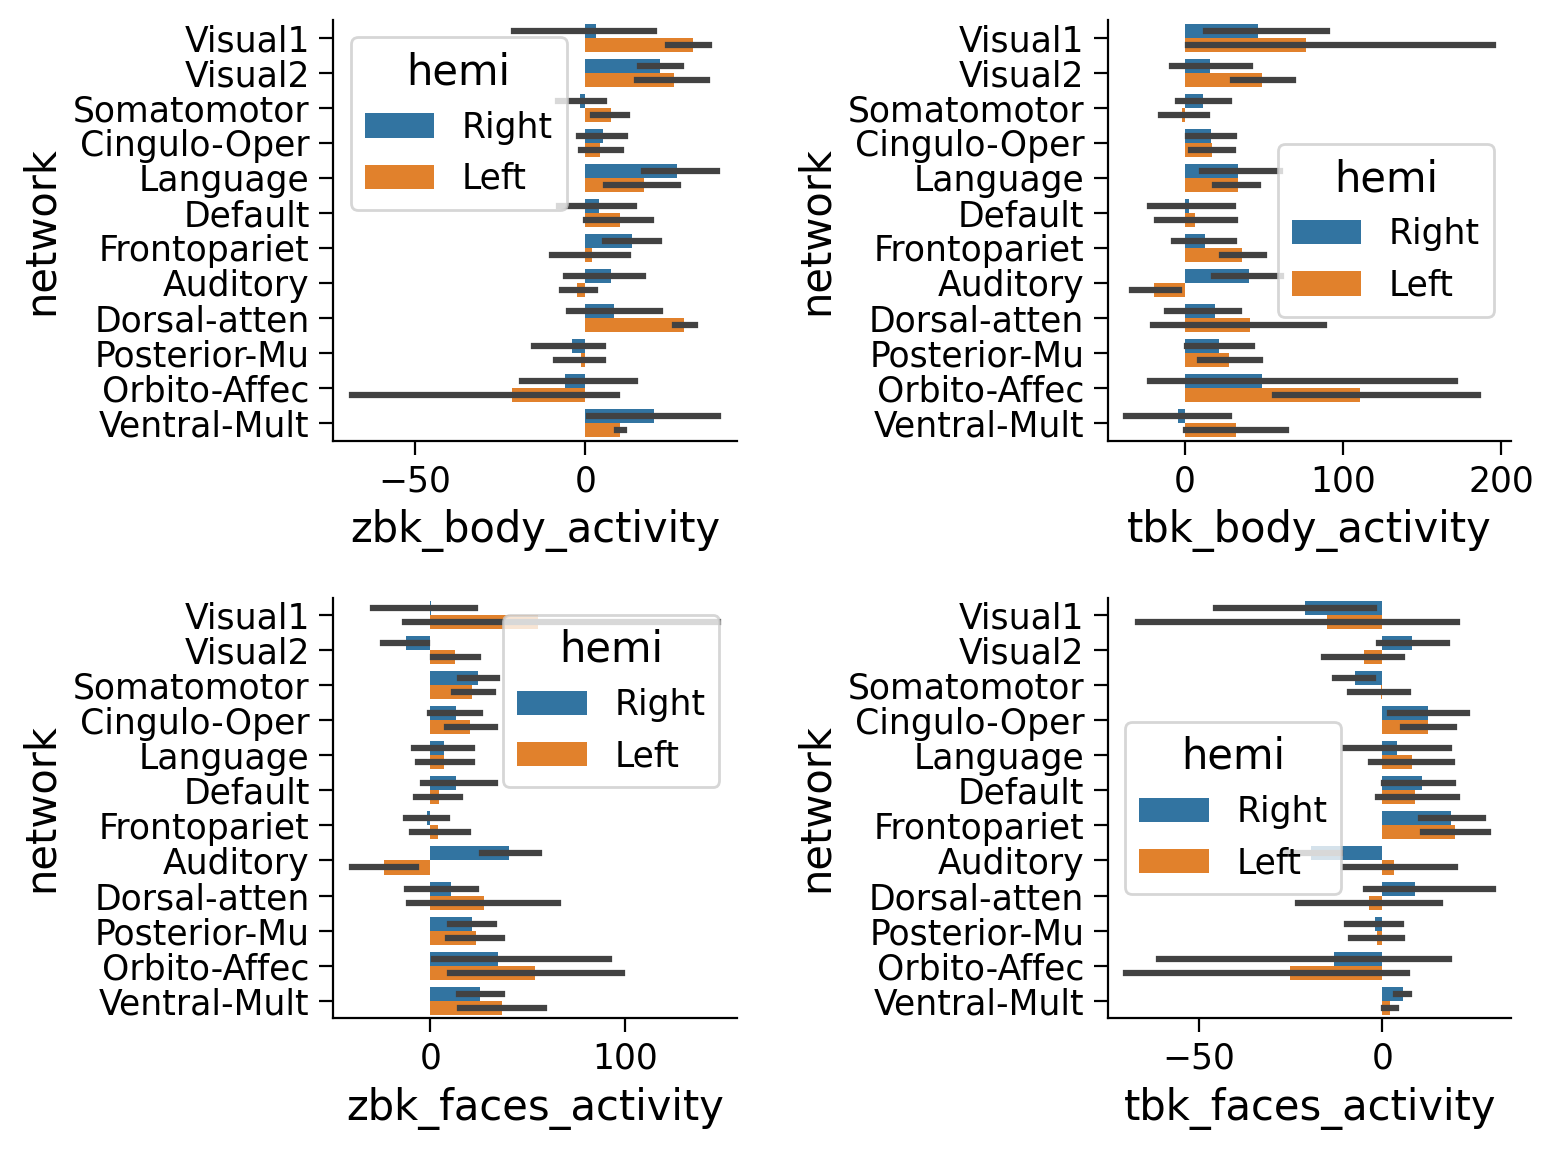

In [ ]:
df = pd.DataFrame({'zbk_body_activity' : zbk_body_activity,
                   'tbk_body_activity' : tbk_body_activity,
                   'zbk_faces_activity' : zbk_faces_activity,
                   'tbk_faces_activity' : tbk_faces_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
sns.barplot(y='network', x='zbk_body_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='tbk_body_activity', data=df, hue='hemi',ax=ax2)
sns.barplot(y='network', x='zbk_faces_activity', data=df, hue='hemi',ax=ax3)
sns.barplot(y='network', x='tbk_faces_activity', data=df, hue='hemi',ax=ax4)
plt.show()

[[ 133.73575285   83.6367881    54.77566969 ...  -55.3652463
   -71.56433972  -67.91427668]
 [  62.86462918   72.5606484    45.36647951 ...   16.62957316
    -1.63379033  -79.09247917]
 [ 136.59607877  118.90086949   79.92411644 ...   16.64831296
   -16.59801104  -20.01792497]
 [ 126.67418185   87.2514221    58.23970985 ...  -70.86130588
   -94.72965193  -57.48425769]
 [  82.02230746   32.12354209   15.39191103 ... -100.74775288
  -135.91145374 -142.68129316]]
[[ 1.          0.57765883  0.11095972 ...  0.0364476   0.10107495
   0.17944777]
 [ 0.57765883  1.          0.11688768 ...  0.0320919   0.17716889
   0.12903019]
 [ 0.11095972  0.11688768  1.         ... -0.12903071  0.0794589
  -0.09444378]
 ...
 [ 0.0364476   0.0320919  -0.12903071 ...  1.         -0.00215034
   0.25900714]
 [ 0.10107495  0.17716889  0.0794589  ... -0.00215034  1.
   0.11104475]
 [ 0.17944777  0.12903019 -0.09444378 ...  0.25900714  0.11104475
   1.        ]]


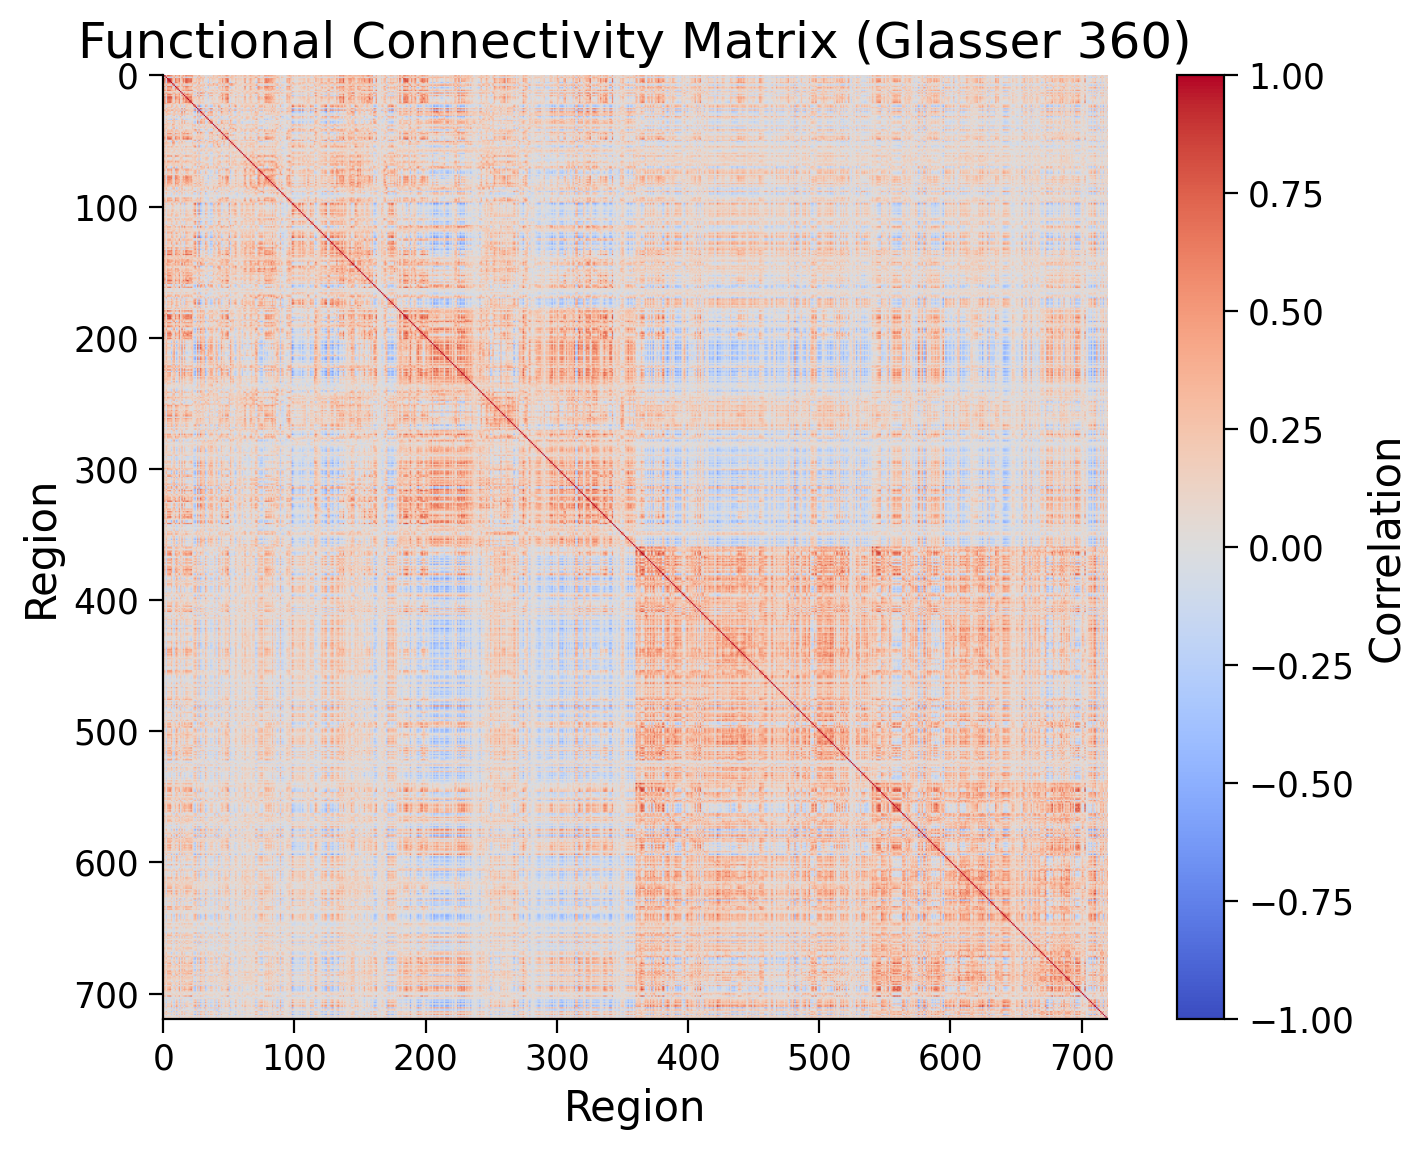

In [ ]:
ts_data_r0 = load_single_timeseries(subject='100307', experiment='WM', run=0)
ts_data_r1 = load_single_timeseries(subject='100307', experiment='WM', run=1)


#print("Shape of data:", data.shape)


#print("First 5 region time series:")
print(ts_data_r0[:5])

fc_matrix = np.corrcoef(ts_data_r0, ts_data_r1)
print(fc_matrix)


import matplotlib.pyplot as plt

plt.imshow(fc_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Functional Connectivity Matrix (Glasser 360)')
plt.xlabel('Region')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import os # Make sure os is imported for path operations

# --- get_network_mean_activity Function Definition ---
def get_network_mean_activity(data, region_info_dict, network_name_to_find):
    """
    Calculates the mean BOLD activity time series for a specified network.

    Args:
        data (np.ndarray): BOLD timeseries data (n_parcels x n_timepoints).
        region_info_dict (dict): Dictionary containing region information,
                               expected to have a 'network' key (np.ndarray of network names).
                               Example: dict(name=..., network=..., hemi=...)
        network_name_to_find (str): The name of the network for which to calculate the mean activity.

    Returns:
        np.ndarray: A 1D array representing the mean BOLD activity time series for the network.
                    Returns an empty array if the network is not found or has no parcels.

    Raises:
        ValueError: If region_info_dict is incorrectly formatted.
    """
    # Check if region_info_dict contains a 'network' key and its value is a numpy array
    if 'network' not in region_info_dict or not isinstance(region_info_dict['network'], np.ndarray):
        raise ValueError("region_info_dict must contain a 'network' key with a numpy array of network names.")

    # Find all parcel indices belonging to the specified network
    # network_mask is a boolean array indicating which parcels belong to the current network
    network_mask = (region_info_dict['network'] == network_name_to_find)
    parcel_indices = np.where(network_mask)[0] # np.where returns a tuple, take the first element for the index array

    # If no parcels are found for this network
    if len(parcel_indices) == 0:
        print(f"Warning: Network '{network_name_to_find}' not found or contains no parcels.")
        return np.array([]) # Return an empty array indicating not found or no data

    # Extract signals for these parcels from the BOLD data
    # 'data' shape is (n_parcels, n_timepoints)
    network_data = data[parcel_indices, :]

    # Check if the extracted data is empty, which might happen if a network has parcels but no valid timepoints
    if network_data.shape[1] == 0:
        print(f"Warning: Network '{network_name_to_find}' has parcels but no valid timepoints. Returning empty array.")
        return np.array([])

    # Calculate the mean of these parcels along axis=0 (parcel dimension)
    # np.mean automatically handles non-NaN values; use np.nanmean for more complex NaN handling if needed
    mean_activity = np.mean(network_data, axis=0)

    return mean_activity

In [ ]:
import numpy as np

def calculate_network_correlation(data: np.ndarray, region_info: dict, network_name1: str, network_name2: str) -> float:
    """
    Calculates the Pearson correlation coefficient between the average BOLD time series
    of two specified brain networks.

    Args:
        data (np.ndarray): The complete BOLD time series data (n_parcels x n_timepoints).
        region_info (dict): A dictionary containing region information (must have a 'network' key).
        network_name1 (str): The name of the first network.
        network_name2 (str): The name of the second network.

    Returns:
        float: The Pearson correlation coefficient between the average time series of the two networks.
               Returns NaN if any network is not found, has no data, or if time series lengths mismatch.

    Raises:
        ValueError: If region_info is incorrectly formatted.
    """
    # Ensure the get_network_mean_activity function is available (it should be defined earlier in your script)
    # from your_module import get_network_mean_activity # If in a different file, you'd need to import it

    mean_bold_network1 = get_network_mean_activity(data, region_info, network_name1)
    mean_bold_network2 = get_network_mean_activity(data, region_info, network_name2)

    if mean_bold_network1.size == 0 or mean_bold_network2.size == 0:
        print(f"Warning: Cannot calculate correlation between {network_name1} and {network_name2} "
              "because at least one network's average time series is empty.")
        return np.nan
    elif len(mean_bold_network1) != len(mean_bold_network2):
        print(f"Warning: Cannot calculate correlation between {network_name1} and {network_name2} "
              "because time series lengths do not match.")
        return np.nan
    else:
        correlation_matrix = np.corrcoef(mean_bold_network1, mean_bold_network2)
        correlation_value = correlation_matrix[0, 1]
        return correlation_value

# --- Example Usage ---
my_subj = '100307'
my_exp = 'WM'
my_run = 0
# The 'default_network_mean' and 'cingulo_oper_mean' variables can be removed;
# use the function directly instead.
# default_network_mean = get_network_mean_activity(full_bold_data, region_info, 'Default')
# cingulo_oper_mean = get_network_mean_activity(full_bold_data, region_info, 'Cingulo-Oper')
full_bold_data = load_single_timeseries(subject=my_subj,
                                     experiment=my_exp,
                                     run=my_run,
                                     remove_mean=True)

# Calculate and print the correlation
correlation_between_networks = calculate_network_correlation(
    full_bold_data, region_info, 'Default', 'Cingulo-Oper'
)

if not np.isnan(correlation_between_networks):
    print(f"\nCorrelation between Default Network and Cingulo-Oper Network: {correlation_between_networks:.4f}")
else:
    print("Unable to calculate inter-network correlation.")


Correlation between Default Network and Cingulo-Oper Network: 0.5113


In [ ]:
subject_ids_to_process = [
    '100307', '100408', '101915', '102816', '103414', '103515', '103818', '105115',
    '105216', '106016', '106319', '110411', '111009', '111312', '111514', '111716',
    '113215', '113619', '114924', '115320', '117122', '117324', '118730', '118932',
    '119833', '120111', '120212', '122317', '123117', '124422', '125525', '126325',
    '127933', '128632', '129028', '130013', '130316', '130922', '131924', '133625',
    '133827', '133928', '134324', '135932', '136833', '137128', '138231', '138534',
    '139637', '140824', '142828', '143325', '148032', '148335', '149337', '149539',
    '150524', '151223', '151526', '151627', '153025', '153429', '154431', '156233',
    '156637', '157336', '158035', '158540', '159239', '159340', '160123', '161731',
    '162329', '162733', '163129', '163432', '167743', '172332', '175439', '176542',
    '178950', '182739', '185139', '188347', '189450', '190031', '192439', '192540',
    '193239', '194140', '196144', '196750', '197550', '198451', '199150', '199655',
    '200614', '201111', '201414', '205119'
]

experiment_name = 'WM'
run_index = 0
networks_for_fc = ['Auditory', 'Cingulo-Oper', 'Default', 'Frontopariet',
                   'Language', 'Orbito-Affec', 'Posterior-Mu', 'Somatomotor',
                   'Ventral-Mult', 'Visual1', 'Visual2']
networks_for_fc.sort()
task_phases = {'0bk': '0-back', '2bk': '2-back'}


--- Extracting FC for Subject: 100307 ---

--- Extracting FC for Subject: 100408 ---

--- Extracting FC for Subject: 101915 ---

--- Extracting FC for Subject: 102816 ---

--- Extracting FC for Subject: 103414 ---

--- Extracting FC for Subject: 103515 ---

--- Extracting FC for Subject: 103818 ---

--- Extracting FC for Subject: 105115 ---

--- Extracting FC for Subject: 105216 ---

--- Extracting FC for Subject: 106016 ---

--- Extracting FC for Subject: 106319 ---

--- Extracting FC for Subject: 110411 ---

--- Extracting FC for Subject: 111009 ---

--- Extracting FC for Subject: 111312 ---

--- Extracting FC for Subject: 111514 ---

--- Extracting FC for Subject: 111716 ---

--- Extracting FC for Subject: 113215 ---

--- Extracting FC for Subject: 113619 ---

--- Extracting FC for Subject: 114924 ---

--- Extracting FC for Subject: 115320 ---

--- Extracting FC for Subject: 117122 ---

--- Extracting FC for Subject: 117324 ---

--- Extracting FC for Subject: 118730 ---

--- Extrac

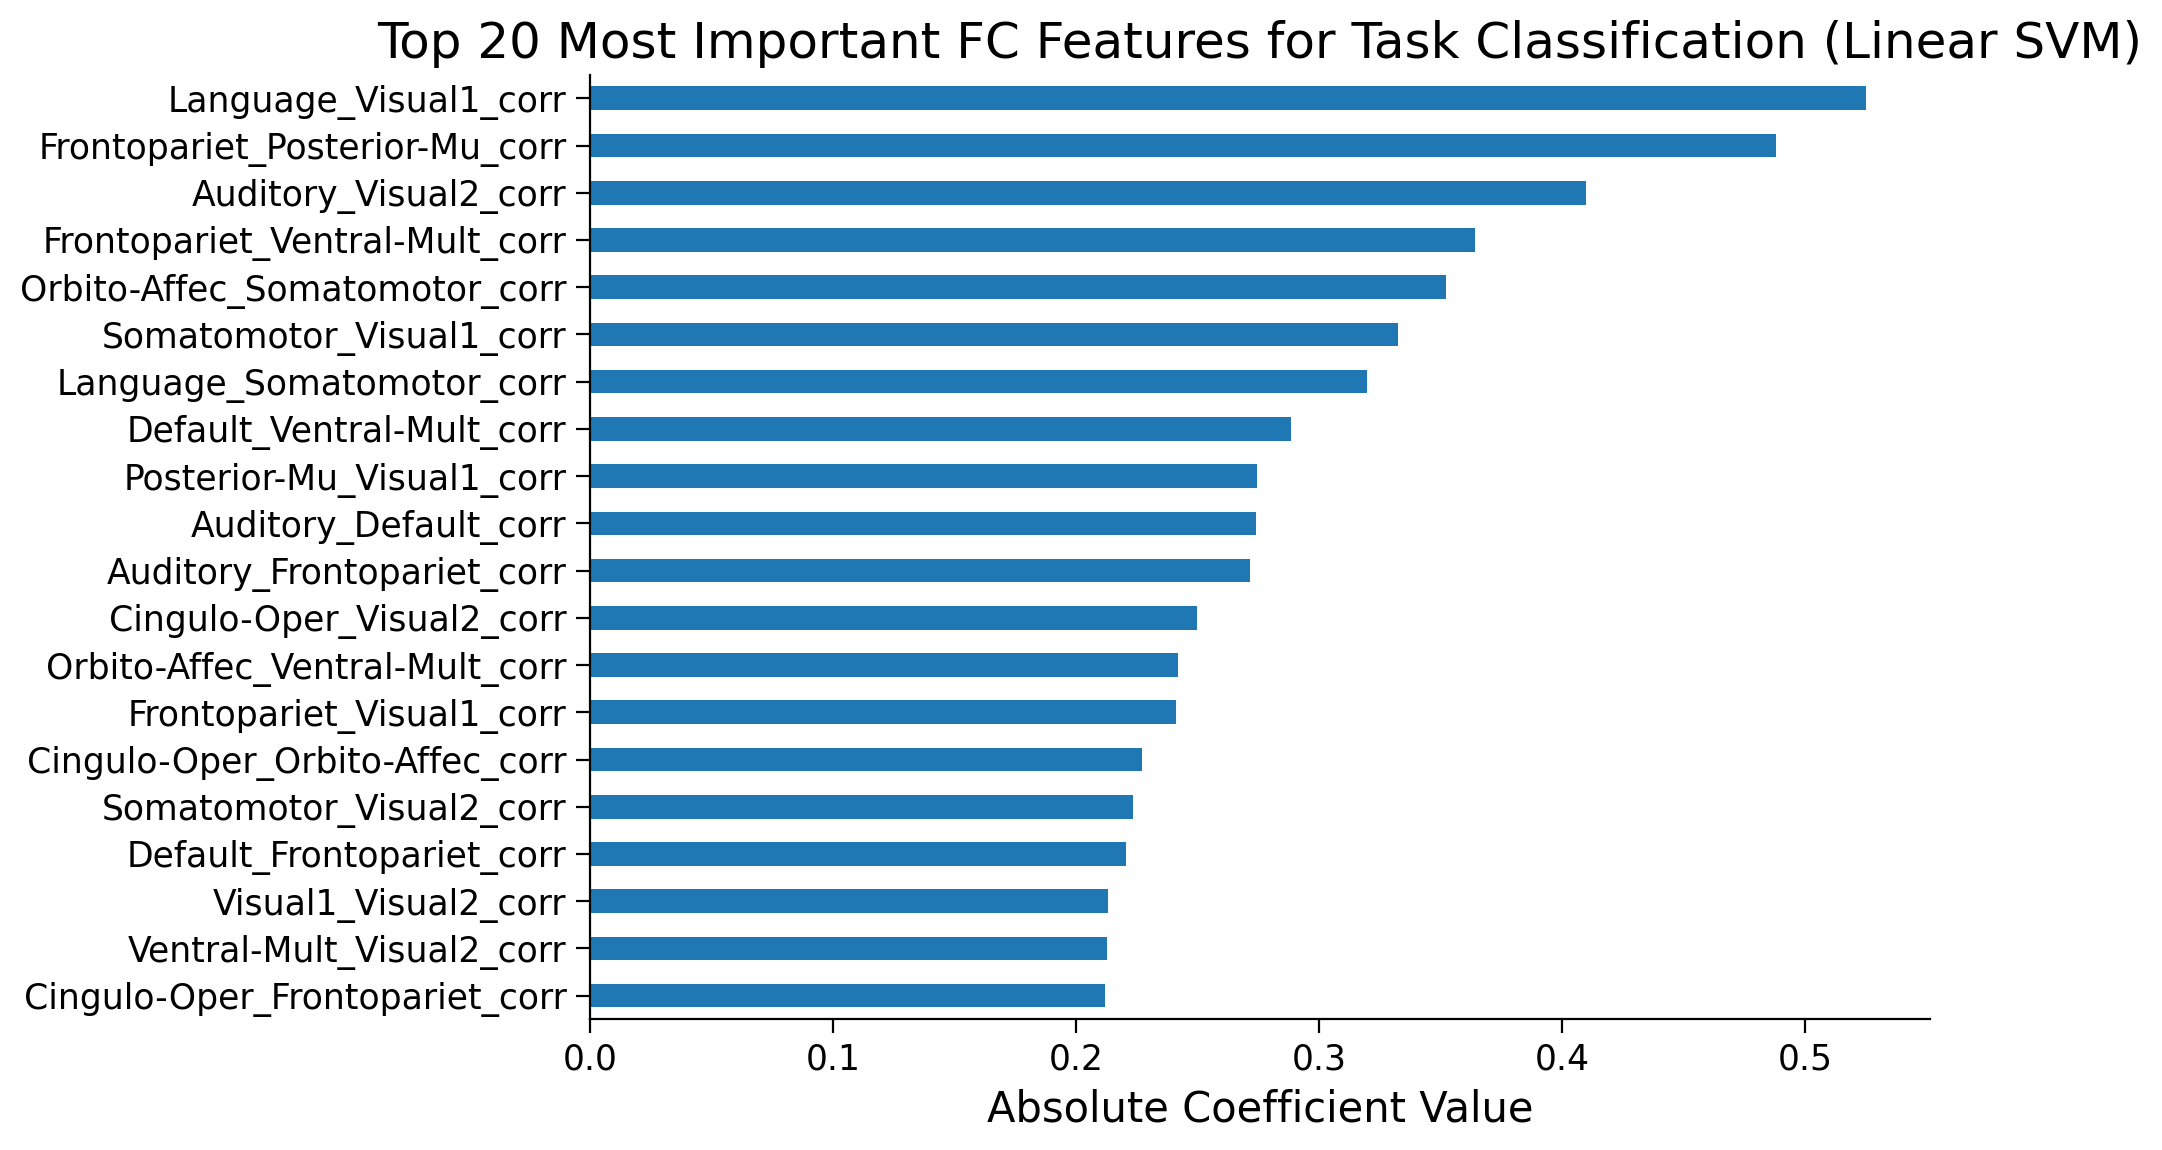

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr # For calculating correlations
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


# Assuming you have collected all_mds_points_data (from previous steps)
# And assuming you have access to your full_bold_data, region_info_dict, etc. from earlier processing.

# --- Step 1: Data Collection and Feature Extraction ---
# This part would replace your MDS calculation loop, or run alongside it.
# You'll need access to the full_bold_data for each subject and task phase.

all_features = []
all_labels = [] # 0 for 0-back, 1 for 2-back
feature_column_names = [] # To store names like 'NetworkA_NetworkB_corr'

# Re-using parts of your existing processing loop structure
# Make sure HCP_DIR, TR, RUNS, EXPERIMENTS, N_PARCELS_EXPECTED are defined
# Make sure load_single_timeseries, load_evs, get_network_mean_activity are defined
# Make sure region_info_dict is correctly loaded and decoded.

# Define your full list of networks that you will use to calculate connectivity
# This should be your 'all_network_names_for_plot' or a subset of interest.
networks_for_fc = ['Auditory', 'Cingulo-Oper', 'Default', 'Frontopariet',
                   'Language', 'Orbito-Affec', 'Posterior-Mu', 'Somatomotor',
                   'Ventral-Mult', 'Visual1', 'Visual2'] # Example: all 12 networks
networks_for_fc.sort() # Ensure consistent order for feature vector

# Pre-generate feature column names (useful for pandas DataFrame)
for i in range(len(networks_for_fc)):
    for j in range(i + 1, len(networks_for_fc)):
        feature_column_names.append(f"{networks_for_fc[i]}_{networks_for_fc[j]}_corr")


# Loop through subjects and tasks to extract features
for current_subject_id in subject_ids_to_process:
    print(f"\n--- Extracting FC for Subject: {current_subject_id} ---")

    full_bold_data = None
    frames_list_data = None
    detailed_condition_names = []

    try:
        full_bold_data = load_single_timeseries(current_subject_id, experiment_name, run_index, remove_mean=True)
        detailed_condition_names = EXPERIMENTS[experiment_name]['cond']
        frames_list_data = load_evs(current_subject_id, experiment_name, run_index)
    except (FileNotFoundError, KeyError, ValueError, Exception) as e:
        print(f"Error loading data for {current_subject_id}: {e}. Skipping subject.")
        continue

    # Loop through 0-back and 2-back tasks
    for phase_key, phase_display_name in task_phases.items():
        label = 0 if phase_key == '0bk' else 1 # Assign label based on task

        condition_indices = [i for i, cond_name in enumerate(detailed_condition_names) if phase_key in cond_name]
        all_phase_trs = []
        for idx in condition_indices:
            for trial_frames in frames_list_data[idx]:
                all_phase_trs.extend(trial_frames.tolist())
        unique_phase_trs = np.sort(np.unique(all_phase_trs))

        if len(unique_phase_trs) == 0:
            print(f"Warning: No TRs found for {current_subject_id}, {phase_display_name}. Skipping.")
            continue

        max_tr_index = full_bold_data.shape[1] - 1
        valid_phase_trs = unique_phase_trs[unique_phase_trs <= max_tr_index]
        if len(valid_phase_trs) == 0:
            print(f"Warning: No valid TRs after range check for {current_subject_id}, {phase_display_name}. Skipping.")
            continue

        bold_data_phase = full_bold_data[:, valid_phase_trs]

        # Get mean time series for selected networks
        network_time_series = []
        actual_networks_in_phase = []
        for net_name in networks_for_fc: # Use the full list of networks for FC
            mean_ts = get_network_mean_activity(bold_data_phase, region_info, net_name)
            if mean_ts.size > 0:
                network_time_series.append(mean_ts)
                actual_networks_in_phase.append(net_name)
            else:
                print(f"Warning: Network '{net_name}' has no valid time series for {current_subject_id}, {phase_display_name}. Skipping for FC calculation.")

        if len(network_time_series) < 2: # Need at least 2 networks to calculate correlation
            print(f"Warning: Not enough networks with valid time series for FC for {current_subject_id}, {phase_display_name}. Skipping.")
            continue

        stacked_network_ts = np.vstack(network_time_series)

        # Calculate pairwise correlations
        fc_values = []
        for i in range(len(actual_networks_in_phase)):
            for j in range(i + 1, len(actual_networks_in_phase)):
                # Ensure networks exist in the 'networks_for_fc' list to match column names
                # This also implicitly handles cases where some networks might have been skipped due to no data
                # If a network pair is missing, its feature value would implicitly be 0 or NaN later.
                # A more robust approach might build a full matrix then extract.
                corr, _ = pearsonr(stacked_network_ts[i, :], stacked_network_ts[j, :])
                fc_values.append(corr)

        # Make sure the length of fc_values matches the expected feature_column_names length
        # This is important if 'actual_networks_in_phase' might be a subset of 'networks_for_fc'
        # A safer approach might be to compute a full correlation matrix for all 'networks_for_fc'
        # and then extract upper triangle, filling NaNs if some networks had no data.

        # For simplicity, let's assume actual_networks_in_phase usually matches networks_for_fc,
        # otherwise, this part needs more sophisticated handling (e.g., initializing a full FC matrix
        # with NaNs and filling it, then flattening).
        if len(fc_values) == len(feature_column_names): # This check is important
             all_features.append(fc_values)
             all_labels.append(label)
        else:
            print(f"Error: FC feature count mismatch for {current_subject_id}, {phase_display_name}. Expected {len(feature_column_names)}, got {len(fc_values)}. Skipping.")


if not all_features:
    print("No features extracted. Cannot proceed with SVM.")
    exit()

# Create a DataFrame for easier management
X_df = pd.DataFrame(all_features, columns=feature_column_names)
y_df = pd.Series(all_labels, name='task_label')

print(f"\nTotal samples for SVM: {len(X_df)}")
print(f"Number of features (network connections): {X_df.shape[1]}")
print(f"Sample X_df head:\n{X_df.head()}")
print(f"Sample y_df head:\n{y_df.head()}")

# --- Step 2: Prepare for SVM ---
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42, stratify=y_df)

# Standardize features (crucial for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 3: Train and Evaluate SVM ---
# Choose an SVM model (e.g., SVC for classification)
# Start with RBF kernel, as it's often a good general-purpose choice for non-linear relationships.
# C: Regularization parameter. Smaller C for more tolerance to misclassification.
# gamma: Kernel coefficient. 'scale' is often a good default.
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
print("\n--- SVM Classification Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['0-back', '2-back']))

# --- Optional: Hyperparameter Tuning with GridSearchCV ---
print("\n--- Performing GridSearchCV for optimal SVM parameters ---")
param_grid = {
    'C': [0.06,0.07,0.08,0.1,0.11, 1],
    'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("\nBest parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_svm_model = grid_search.best_estimator_
y_pred_best = best_svm_model.predict(X_test_scaled)

print("\n--- Best SVM Model Test Set Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_best, target_names=['0-back', '2-back']))

if best_svm_model.kernel == 'linear':
    # Get the coefficients from the linear SVM model.
    # For a binary classification problem, coef_ will have shape (1, n_features).
    coefficients = best_svm_model.coef_[0]

    # Create a Pandas Series to easily associate coefficients with feature names
    feature_importance = pd.Series(coefficients, index=X_df.columns)

    # Sort the features by the absolute value of their coefficients in descending order.
    # Features with larger absolute coefficients are considered more important
    # as they have a stronger influence on the decision boundary.
    sorted_importance = feature_importance.abs().sort_values(ascending=False)

    print("\n--- Most Important FC Features (Absolute Linear Kernel Coefficients) ---")
    print(sorted_importance.head(10)) # Print the top 10 most important features

    # Visualize the top 20 most important features.
    plt.figure(figsize=(10, 6))
    sorted_importance.head(20).plot(kind='barh') # Create a horizontal bar plot
    plt.title('Top 20 Most Important FC Features for Task Classification (Linear SVM)')
    plt.xlabel('Absolute Coefficient Value')
    plt.gca().invert_yaxis() # Invert y-axis to show the most important feature at the top
    plt.show()

True model accuracy: 0.8000
Performing 10000 permutation tests...
Completed 100/10000 permutations
Completed 200/10000 permutations
Completed 300/10000 permutations
Completed 400/10000 permutations
Completed 500/10000 permutations
Completed 600/10000 permutations
Completed 700/10000 permutations
Completed 800/10000 permutations
Completed 900/10000 permutations
Completed 1000/10000 permutations
Completed 1100/10000 permutations
Completed 1200/10000 permutations
Completed 1300/10000 permutations
Completed 1400/10000 permutations
Completed 1500/10000 permutations
Completed 1600/10000 permutations
Completed 1700/10000 permutations
Completed 1800/10000 permutations
Completed 1900/10000 permutations
Completed 2000/10000 permutations
Completed 2100/10000 permutations
Completed 2200/10000 permutations
Completed 2300/10000 permutations
Completed 2400/10000 permutations
Completed 2500/10000 permutations
Completed 2600/10000 permutations
Completed 2700/10000 permutations
Completed 2800/10000 perm

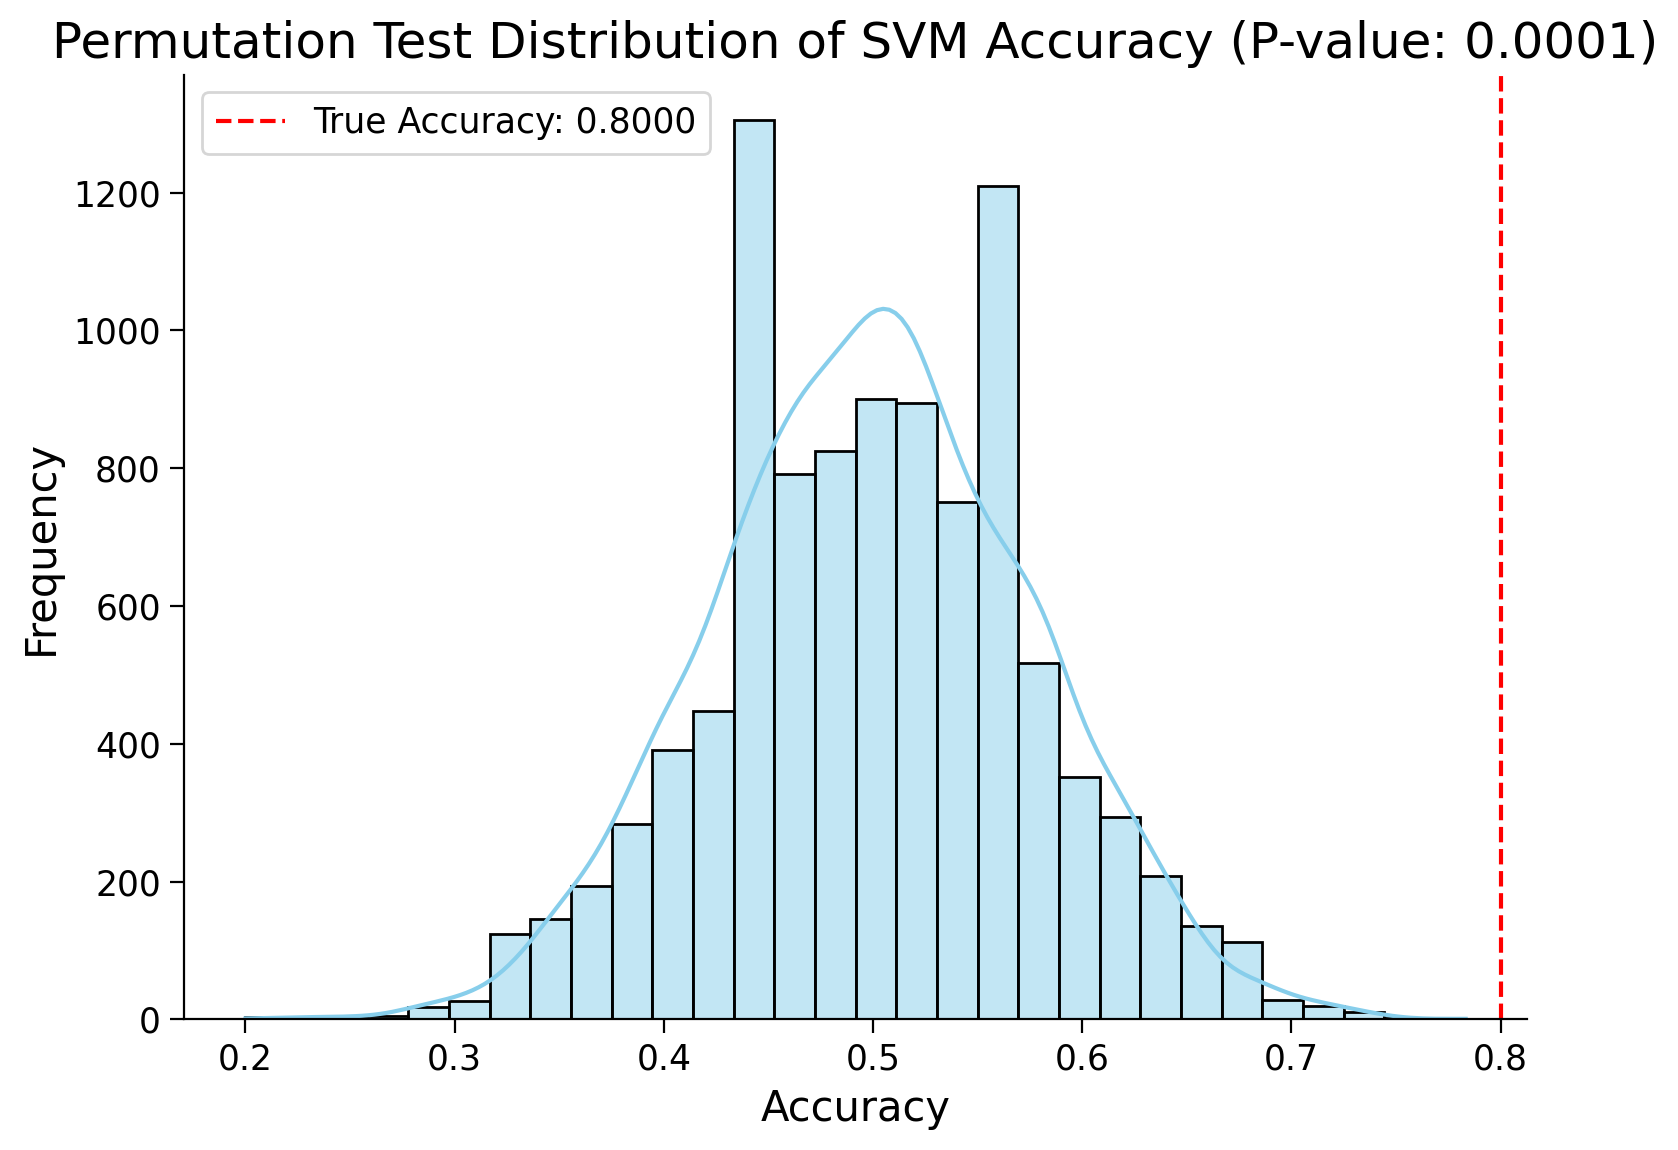


Conclusion: The model's classification performance is statistically significant, better than random chance.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle # Used to shuffle data

# Assuming X_df, y_df, best_svm_model (your optimized SVM model), X_test_scaled, and y_test are ready.
# If X_df is very large, for speed, you might want to perform permutations on the original
# X_df and y_df first, then proceed with train_test_split and standardization in each loop
# to truly simulate the entire process. Here, we simplify by shuffling labels within the
# training set and retraining the model.

n_permutations = 10000 # Number of permutations; typically 1000 or more are needed

# 1. Calculate the accuracy of the true model (using your best model on the test set).
# Assuming best_svm_model is an already trained model.
y_pred_true = best_svm_model.predict(X_test_scaled)
true_accuracy = accuracy_score(y_test, y_pred_true)
print(f"True model accuracy: {true_accuracy:.4f}")

# Store accuracies from each permutation.
permutation_accuracies = []

print(f"Performing {n_permutations} permutation tests...")
for i in range(n_permutations):
    # Shuffle the training labels.
    # Note: This approach shuffles only the training labels and retrains the model
    # in each iteration. A more rigorous method would be to shuffle the labels
    # of the entire dataset, then re-run train_test_split and fit.
    # Considering computational cost, shuffling training labels and retraining is
    # often a balanced choice.
    y_train_shuffled = shuffle(y_train, random_state=i) # Use a different random seed for each shuffle

    # Retrain the model (using the parameters of the best model).
    # A new model is trained for each permutation.
    perm_model = SVC(**best_svm_model.get_params()) # Copy parameters from the best model
    perm_model.fit(X_train_scaled, y_train_shuffled) # Train with shuffled labels

    # Make predictions on the original test set (test labels remain unchanged).
    y_pred_perm = perm_model.predict(X_test_scaled)
    perm_accuracy = accuracy_score(y_test, y_pred_perm)
    permutation_accuracies.append(perm_accuracy)

    if (i + 1) % 100 == 0:
        print(f"Completed {i+1}/{n_permutations} permutations")

# Convert results to a NumPy array for easier calculation.
permutation_accuracies = np.array(permutation_accuracies)

# Calculate the P-value.
# This counts how many times the random accuracy was greater than or equal to the true accuracy.
p_value = (np.sum(permutation_accuracies >= true_accuracy) + 1) / (n_permutations + 1)

print(f"\nPermutation test results (based on {n_permutations} permutations):")
print(f"True model accuracy: {true_accuracy:.4f}")
print(f"Mean permutation accuracy: {np.mean(permutation_accuracies):.4f}")
print(f"Standard deviation of permutation accuracies: {np.std(permutation_accuracies):.4f}")
print(f"P-value: {p_value:.4f}")

# ---
## Visualize the Permutation Distribution

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(permutation_accuracies, kde=True, bins=30, color='skyblue')
plt.axvline(true_accuracy, color='red', linestyle='--', label=f'True Accuracy: {true_accuracy:.4f}')
plt.title(f'Permutation Test Distribution of SVM Accuracy (P-value: {p_value:.4f})')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

if p_value < 0.05:
    print("\nConclusion: The model's classification performance is statistically significant, better than random chance.")
else:
    print("\nConclusion: The model's classification performance is not statistically significant.")

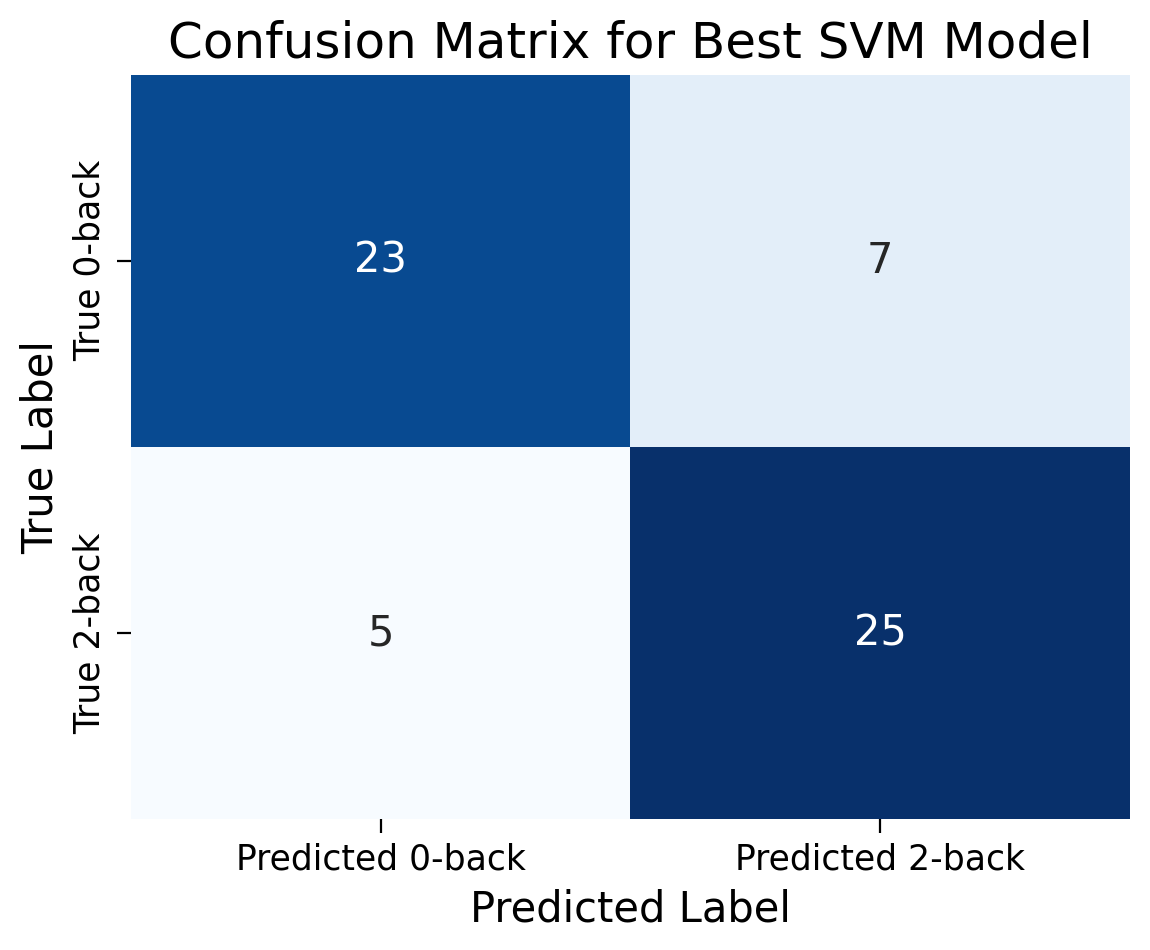

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions using the best model
# Assuming 'best_svm_model' is the optimal model you found and trained via GridSearchCV
y_pred_best = best_svm_model.predict(X_test_scaled)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0-back', 'Predicted 2-back'],  # Labels for predicted classes
            yticklabels=['True 0-back', 'True 2-back'])   # Labels for true classes
plt.title('Confusion Matrix for Best SVM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
subject_ids_to_process = [
    '100307', '100408', '101915', '102816', '103414', '103515', '103818', '105115',
    '105216', '106016', '106319', '110411', '111009', '111312', '111514', '111716',
    '113215', '113619', '114924', '115320', '117122', '117324', '118730', '118932',
    '119833', '120111', '120212', '122317', '123117', '124422', '125525', '126325',
    '127933', '128632', '129028', '130013', '130316', '130922', '131924', '133625',
    '133827', '133928', '134324', '135932', '136833', '137128', '138231', '138534',
    '139637', '140824', '142828', '143325', '148032', '148335', '149337', '149539',
    '150524', '151223', '151526', '151627', '153025', '153429', '154431', '156233',
    '156637', '157336', '158035', '158540', '159239', '159340', '160123', '161731',
    '162329', '162733', '163129', '163432', '167743', '172332', '175439', '176542',
    '178950', '182739', '185139', '188347', '189450', '190031', '192439', '192540',
    '193239', '194140', '196144', '196750', '197550', '198451', '199150', '199655',
    '200614', '201111', '201414', '205119'
]

experiment_name = 'WM'
run_index = 0
networks_for_fc = ['Auditory', 'Cingulo-Oper', 'Default', 'Frontopariet',
                   'Language', 'Orbito-Affec', 'Posterior-Mu', 'Somatomotor',
                   'Ventral-Mult', 'Visual1', 'Visual2']
networks_for_fc.sort()
task_phases = {'0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools'}


--- Extracting FC for Subject: 100307 ---

--- Extracting FC for Subject: 100408 ---

--- Extracting FC for Subject: 101915 ---

--- Extracting FC for Subject: 102816 ---

--- Extracting FC for Subject: 103414 ---

--- Extracting FC for Subject: 103515 ---

--- Extracting FC for Subject: 103818 ---

--- Extracting FC for Subject: 105115 ---

--- Extracting FC for Subject: 105216 ---

--- Extracting FC for Subject: 106016 ---

--- Extracting FC for Subject: 106319 ---

--- Extracting FC for Subject: 110411 ---

--- Extracting FC for Subject: 111009 ---

--- Extracting FC for Subject: 111312 ---

--- Extracting FC for Subject: 111514 ---

--- Extracting FC for Subject: 111716 ---

--- Extracting FC for Subject: 113215 ---

--- Extracting FC for Subject: 113619 ---

--- Extracting FC for Subject: 114924 ---

--- Extracting FC for Subject: 115320 ---

--- Extracting FC for Subject: 117122 ---

--- Extracting FC for Subject: 117324 ---

--- Extracting FC for Subject: 118730 ---

--- Extrac

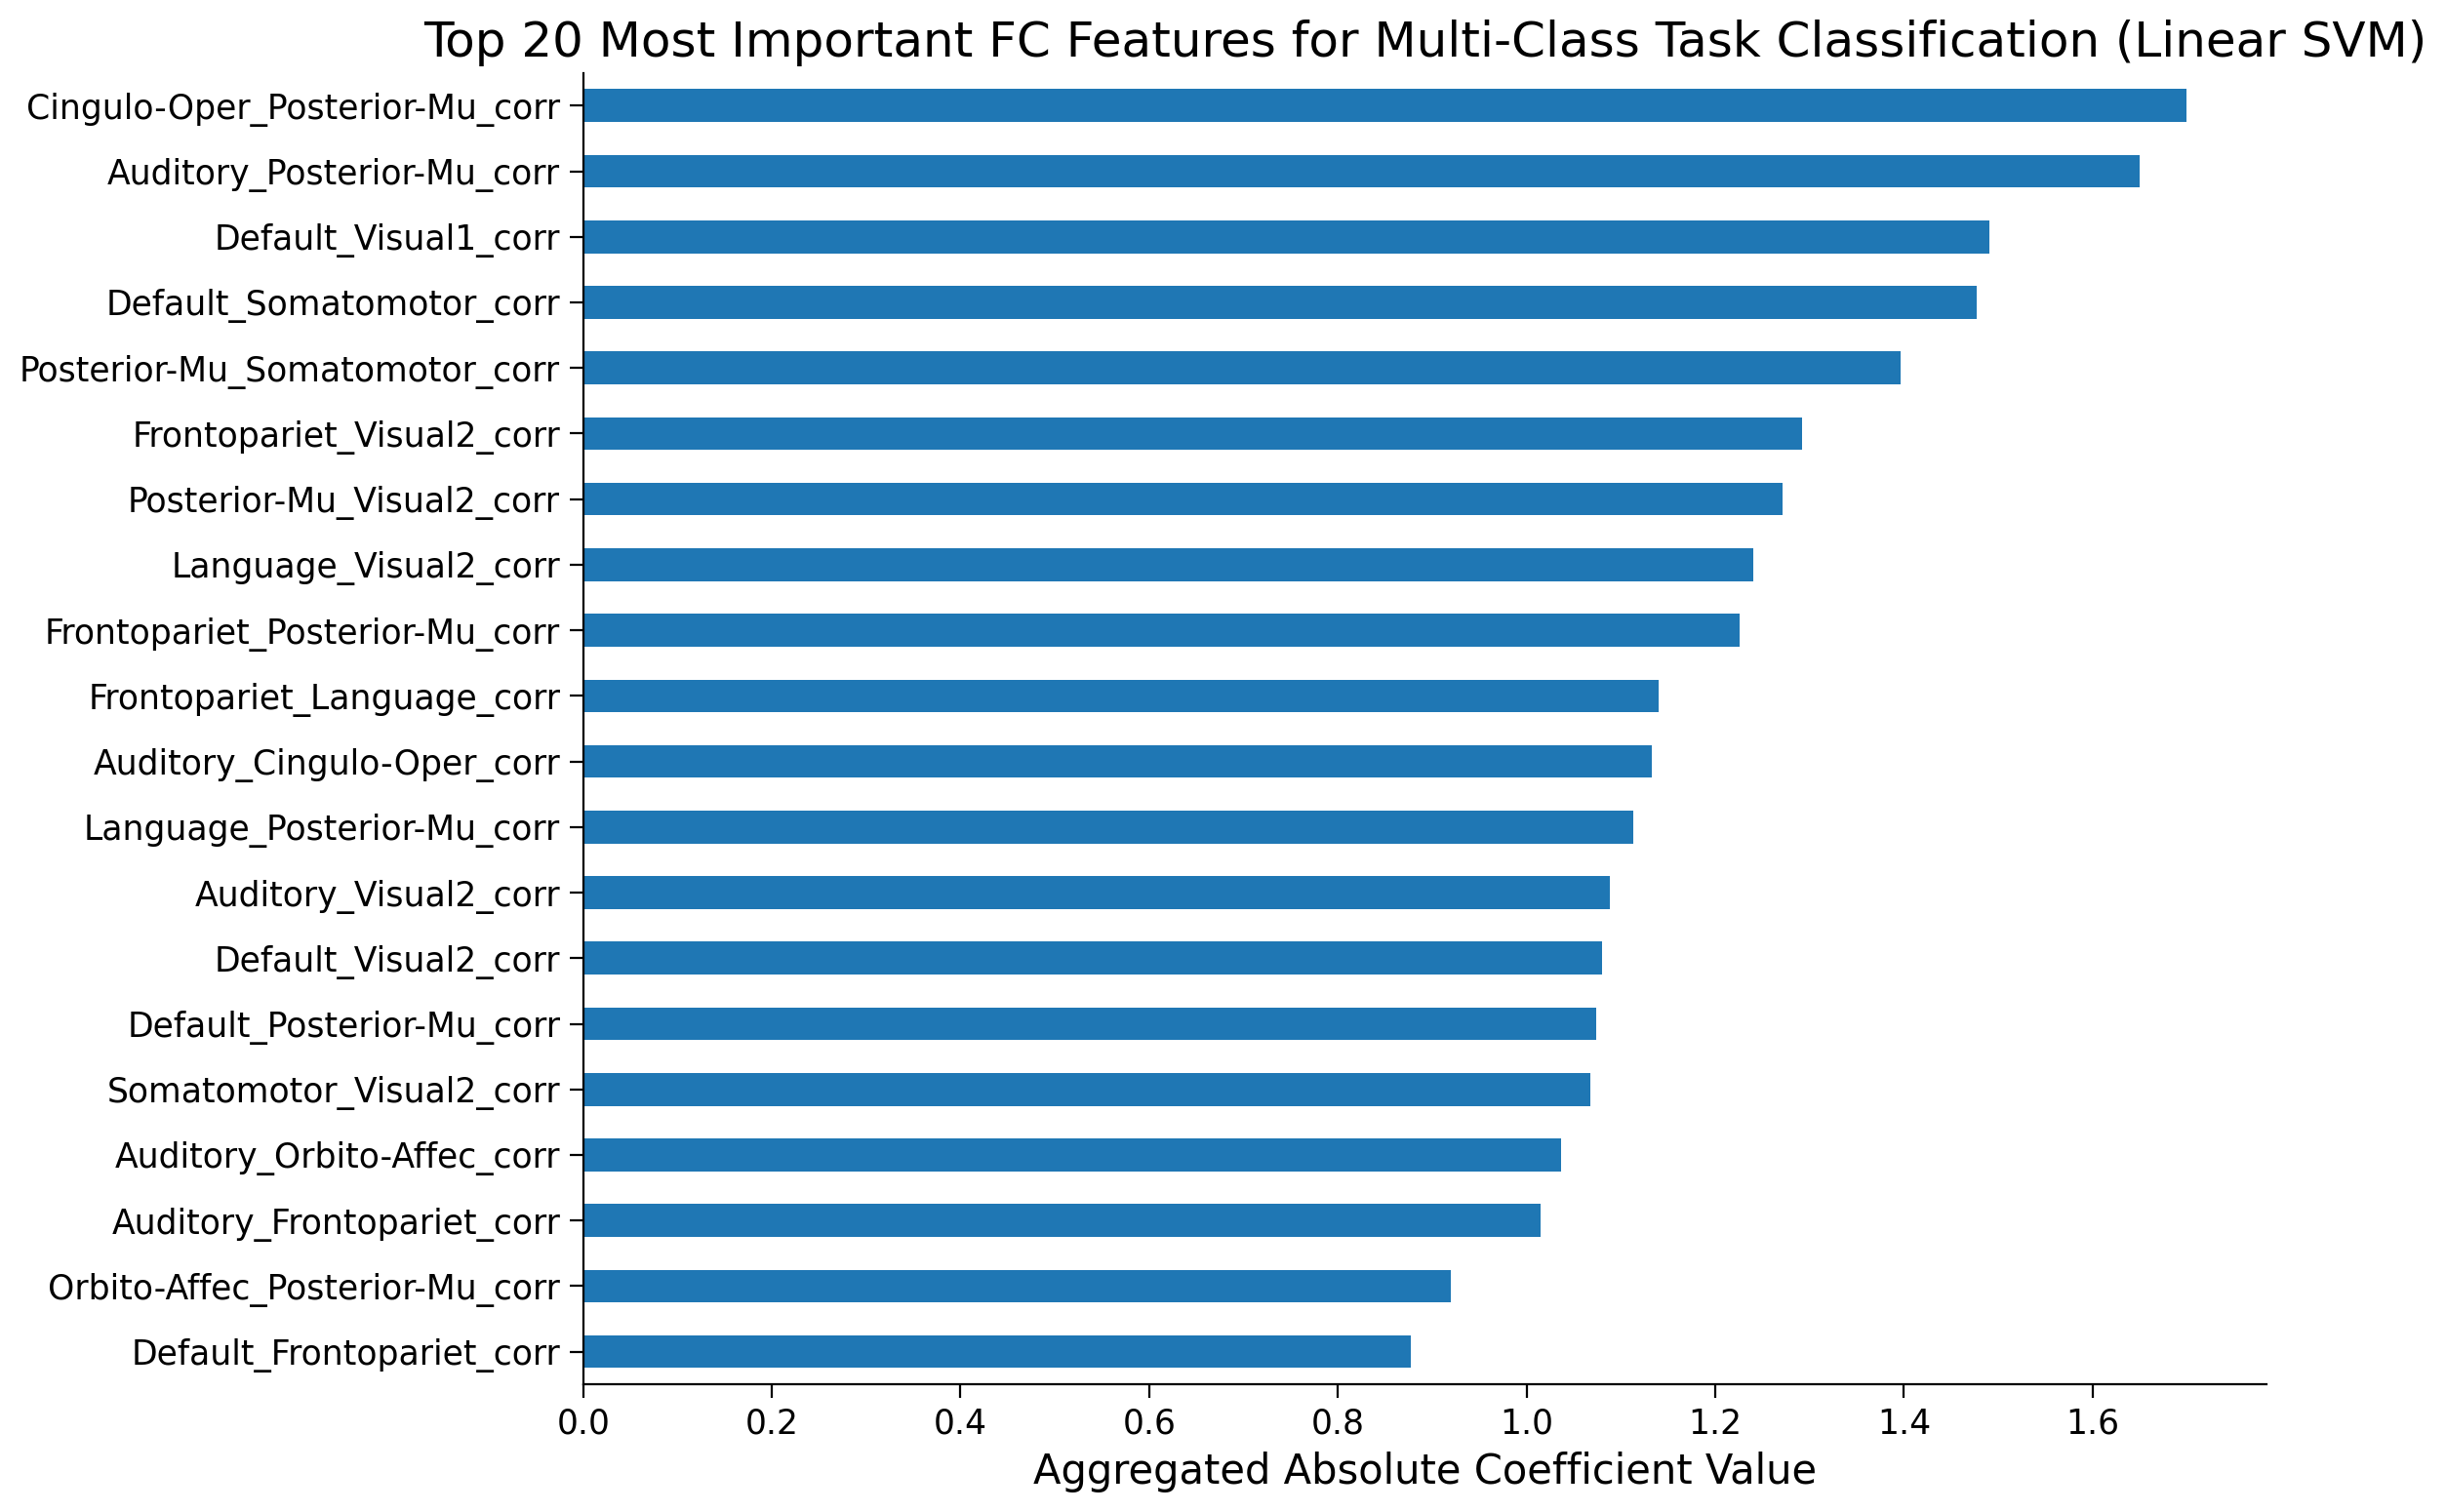

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr # For calculating correlations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt # Import for plotting

# Assuming these are defined elsewhere in your environment
# HCP_DIR, TR, RUNS, EXPERIMENTS, N_PARCELS_EXPECTED
# load_single_timeseries, load_evs, get_network_mean_activity
# region_info_dict
# subject_ids_to_process
# experiment_name
# run_index
# region_info # This should be your region_info_dict or similar structure

# --- Define your new multi-class task phases and their labels ---
# You can map each unique phase_key to a unique integer label
task_phases = {
    '0bk_faces': '0-back Faces',
    '0bk_tools': '0-back Tools',
    '2bk_faces': '2-back Faces',
    '2bk_tools': '2-back Tools'
}

# Create a mapping from phase_key to a numerical label
# This ensures each unique phase gets a unique integer label.
# You can also define specific labels, e.g., {'0bk_body': 0, '0bk_faces': 1, ...}
unique_phase_keys = list(task_phases.keys())
label_mapping = {phase_key: i for i, phase_key in enumerate(unique_phase_keys)}
# Also create a reverse mapping for target_names in the classification report
label_names = {i: display_name for i, (phase_key, display_name) in enumerate(task_phases.items())}


all_features = []
all_labels = []
feature_column_names = [] # To store names like 'NetworkA_NetworkB_corr'

# Define your full list of networks that you will use to calculate connectivity
networks_for_fc = ['Auditory', 'Cingulo-Oper', 'Default', 'Frontopariet',
                   'Language', 'Orbito-Affec', 'Posterior-Mu', 'Somatomotor',
                   'Ventral-Mult', 'Visual1', 'Visual2']
networks_for_fc.sort() # Ensure consistent order for feature vector

# Pre-generate feature column names (useful for pandas DataFrame)
for i in range(len(networks_for_fc)):
    for j in range(i + 1, len(networks_for_fc)):
        feature_column_names.append(f"{networks_for_fc[i]}_{networks_for_fc[j]}_corr")


# Loop through subjects and tasks to extract features
for current_subject_id in subject_ids_to_process:
    print(f"\n--- Extracting FC for Subject: {current_subject_id} ---")

    full_bold_data = None
    frames_list_data = None
    detailed_condition_names = []

    try:
        full_bold_data = load_single_timeseries(current_subject_id, experiment_name, run_index, remove_mean=True)
        detailed_condition_names = EXPERIMENTS[experiment_name]['cond']
        frames_list_data = load_evs(current_subject_id, experiment_name, run_index)
    except (FileNotFoundError, KeyError, ValueError, Exception) as e:
        print(f"Error loading data for {current_subject_id}: {e}. Skipping subject.")
        continue

    # Loop through all defined task phases
    for phase_key, phase_display_name in task_phases.items():
        # Assign the appropriate numerical label based on your mapping
        label = label_mapping.get(phase_key)
        if label is None:
            print(f"Warning: No label defined for phase_key '{phase_key}'. Skipping.")
            continue

        condition_indices = [i for i, cond_name in enumerate(detailed_condition_names) if phase_key in cond_name]
        all_phase_trs = []
        for idx in condition_indices:
            for trial_frames in frames_list_data[idx]:
                all_phase_trs.extend(trial_frames.tolist())
        unique_phase_trs = np.sort(np.unique(all_phase_trs))

        if len(unique_phase_trs) == 0:
            print(f"Warning: No TRs found for {current_subject_id}, {phase_display_name}. Skipping.")
            continue

        max_tr_index = full_bold_data.shape[1] - 1
        valid_phase_trs = unique_phase_trs[unique_phase_trs <= max_tr_index]
        if len(valid_phase_trs) == 0:
            print(f"Warning: No valid TRs after range check for {current_subject_id}, {phase_display_name}. Skipping.")
            continue

        bold_data_phase = full_bold_data[:, valid_phase_trs]

        # Get mean time series for selected networks
        network_time_series = []
        actual_networks_in_phase = []
        for net_name in networks_for_fc:
            mean_ts = get_network_mean_activity(bold_data_phase, region_info, net_name)
            if mean_ts.size > 0:
                network_time_series.append(mean_ts)
                actual_networks_in_phase.append(net_name)
            else:
                print(f"Warning: Network '{net_name}' has no valid time series for {current_subject_id}, {phase_display_name}. Skipping for FC calculation.")

        if len(network_time_series) < 2:
            print(f"Warning: Not enough networks with valid time series for FC for {current_subject_id}, {phase_display_name}. Skipping.")
            continue

        stacked_network_ts = np.vstack(network_time_series)

        # Calculate pairwise correlations
        fc_values = []
        for i in range(len(actual_networks_in_phase)):
            for j in range(i + 1, len(actual_networks_in_phase)):
                corr, _ = pearsonr(stacked_network_ts[i, :], stacked_network_ts[j, :])
                fc_values.append(corr)

        if len(fc_values) == len(feature_column_names):
            all_features.append(fc_values)
            all_labels.append(label)
        else:
            print(f"Error: FC feature count mismatch for {current_subject_id}, {phase_display_name}. Expected {len(feature_column_names)}, got {len(fc_values)}. Skipping.")


if not all_features:
    print("No features extracted. Cannot proceed with SVM.")
    exit()

# Create a DataFrame for easier management
X_df = pd.DataFrame(all_features, columns=feature_column_names)
y_df = pd.Series(all_labels, name='task_label')

print(f"\nTotal samples for SVM: {len(X_df)}")
print(f"Number of features (network connections): {X_df.shape[1]}")
print(f"Sample X_df head:\n{X_df.head()}")
print(f"Sample y_df head:\n{y_df.head()}")

# --- Step 2: Prepare for SVM ---
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42, stratify=y_df)

# Standardize features (crucial for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 3: Train and Evaluate SVM ---
# SVC naturally handles multi-class classification using a one-vs-rest (OvR) or one-vs-one (OvO) strategy.
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_scaled)

# Evaluate the model
print("\n--- SVM Classification Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
# Use the display names for the classification report
report_target_names = [label_names[i] for i in sorted(label_names.keys())]
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=report_target_names))

# --- Optional: Hyperparameter Tuning with GridSearchCV ---
print("\n--- Performing GridSearchCV for optimal SVM parameters ---")
param_grid = {
    'C': [0.01,0.06,0.07,0.08,0.1,0.11,0.5, 1,10],
    'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("\nBest parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

best_svm_model = grid_search.best_estimator_
y_pred_best = best_svm_model.predict(X_test_scaled)

print("\n--- Best SVM Model Test Set Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_best, target_names=report_target_names))

if best_svm_model.kernel == 'linear':
    # For multi-class linear SVM, `coef_` has shape (n_classes, n_features).
    # You'll need to decide how to aggregate or interpret these for "overall" importance.
    # One common approach is to look at the magnitude of coefficients for each feature
    # across all classes.
    coefficients = best_svm_model.coef_

    # Calculate the sum of absolute coefficients for each feature across all classes
    # This provides a general measure of feature importance regardless of the class.
    sum_abs_coefficients = np.sum(np.abs(coefficients), axis=0)
    feature_importance = pd.Series(sum_abs_coefficients, index=X_df.columns)

    # Sort the features by their calculated importance
    sorted_importance = feature_importance.sort_values(ascending=False)

    print("\n--- Most Important FC Features (Aggregated Absolute Linear Kernel Coefficients) ---")
    print(sorted_importance.head(10)) # Print the top 10 most important features

    # Visualize the top 20 most important features.
    plt.figure(figsize=(12, 8)) # Make the figure slightly larger for more labels
    sorted_importance.head(20).plot(kind='barh') # Create a horizontal bar plot
    plt.title('Top 20 Most Important FC Features for Multi-Class Task Classification (Linear SVM)')
    plt.xlabel('Aggregated Absolute Coefficient Value')
    plt.gca().invert_yaxis() # Invert y-axis to show the most important feature at the top
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

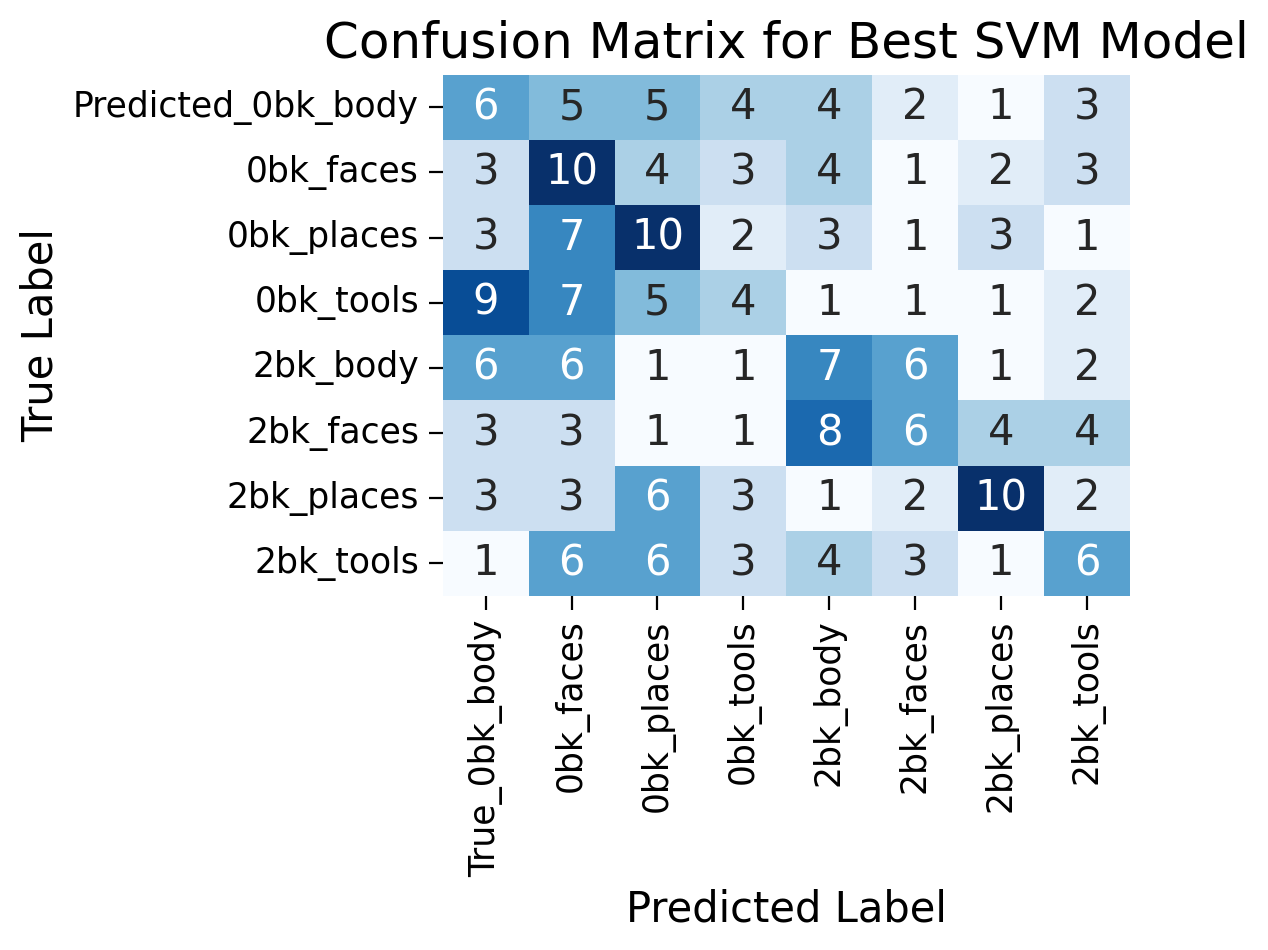

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions using the best model
# Assuming 'best_svm_model' is the optimal model you found and trained via GridSearchCV
y_pred_best = best_svm_model.predict(X_test_scaled)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['True_0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools'],  # Labels for predicted classes
            yticklabels=['Predicted_0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools'])   # Labels for true classes
plt.title('Confusion Matrix for Best SVM Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()